In [2]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression

In [ ]:
!pwd

In [3]:
df = pd.read_csv('null.csv', low_memory=False)
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (101315, 21)


In [4]:
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
tab_info

/var/folders/9p/_jh1pnpx5xd6rbjhsjn79nc80000gn/T/ipykernel_10686/2786031577.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
/var/folders/9p/_jh1pnpx5xd6rbjhsjn79nc80000gn/T/ipykernel_10686/2786031577.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100)


,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
column type,int64,int64,object,object,object,object,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,158,355,158,158,...,158,158,158,158,158,158,158,158,158,158
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.155949,0.350392,0.155949,0.155949,...,0.155949,0.155949,0.155949,0.155949,0.155949,0.155949,0.155949,0.155949,0.155949,0.155949


In [5]:
count_flights = df['airport_name'].value_counts()

In [6]:
print(count_flights)

Nashville, TN: Nashville International                        913
Pittsburgh, PA: Pittsburgh International                      913
Raleigh/Durham, NC: Raleigh-Durham International              906
New Orleans, LA: Louis Armstrong New Orleans International    895
Detroit, MI: Detroit Metro Wayne County                       889
                                                             ... 
St. Augustine, FL: Northeast Florida Regional                   5
Williamsport, PA: Williamsport Regional                         3
Youngstown/Warren, OH: Youngstown-Warren Regional               1
Fort Collins/Loveland, CO: Northern Colorado Regional           1
Tokeen, AK: Tokeen Airport                                      1
Name: airport_name, Length: 384, dtype: int64


In [7]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

,variable,missing values,filling factor (%)
0,arr_del15,355,99.649608
1,nas_ct,158,99.844051
2,nas_delay,158,99.844051
3,weather_delay,158,99.844051
4,carrier_delay,158,99.844051
5,arr_delay,158,99.844051
6,arr_diverted,158,99.844051
7,arr_cancelled,158,99.844051
8,late_aircraft_ct,158,99.844051
9,security_ct,158,99.844051


We see that the variables filling factor is quite good (> 97%). Since the scope of this work is not to establish the state-of-the-art in predicting flight delays, I decide to proceed without trying to impute what's missing and I simply remove the entries that contain missing values.

In [8]:
df.dropna(inplace = True)

In [9]:
df.describe()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
count,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000,100960.000000
mean,2019.515184,6.282518,336.669057,58.073217,18.493519,2.051222,17.268145,0.153786,20.106579,7.964828,0.774683,3824.531220,1321.840987,213.024643,839.930705,7.384776,1442.342948
std,1.559895,3.440055,943.091834,163.327000,47.080815,6.884791,58.479922,0.734822,63.098420,50.986874,3.398931,11725.452846,3944.873970,811.010107,3393.552629,44.338997,4640.573106
min,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.000000,3.000000,42.000000,5.000000,1.930000,0.000000,0.970000,0.000000,1.000000,0.000000,0.000000,268.000000,87.000000,0.000000,25.000000,0.000000,42.000000
50%,2019.000000,6.000000,90.000000,14.000000,5.300000,0.250000,3.210000,0.000000,3.980000,1.000000,0.000000,869.000000,318.000000,12.000000,120.000000,0.000000,255.000000
75%,2021.000000,9.000000,227.000000,40.000000,14.640000,1.670000,9.880000,0.000000,12.680000,4.000000,1.000000,2525.000000,992.000000,132.000000,402.000000,0.000000,919.000000
max,2022.000000,12.000000,21931.000000,4176.000000,1147.000000,226.000000,1884.420000,58.690000,1531.810000,4951.000000,154.000000,429194.000000,151581.000000,28294.000000,112018.000000,3760.000000,147167.000000


In [10]:
print("Nb of airports: {}".format(len(df['airport'].unique())))

Nb of airports: 383


In [11]:
df.corr()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
year,1.000000,-0.155292,-0.045588,-0.052033,0.003336,-0.006049,-0.078586,0.041262,-0.064160,0.020846,-0.029124,-0.042670,0.000536,-0.005473,-0.073646,0.025040,-0.053697
month,-0.155292,1.000000,0.002900,0.000730,0.003804,-0.013703,-0.003595,0.015542,0.003698,-0.062236,-0.002336,-0.003591,-0.002083,-0.017889,-0.006355,0.011269,0.000362
arr_flights,-0.045588,0.002900,1.000000,0.912000,0.888081,0.721881,0.807804,0.452611,0.865310,0.394523,0.642070,0.873379,0.873863,0.650280,0.691074,0.370907,0.841372
arr_del15,-0.052033,0.000730,0.912000,1.000000,0.933790,0.758786,0.908542,0.480457,0.961273,0.334992,0.699186,0.968492,0.901808,0.688448,0.825927,0.387705,0.952495
carrier_ct,0.003336,0.003804,0.888081,0.933790,1.000000,0.740101,0.740158,0.504663,0.898304,0.326138,0.640702,0.895217,0.938763,0.657001,0.642851,0.412084,0.875077
weather_ct,-0.006049,-0.013703,0.721881,0.758786,0.740101,1.000000,0.661968,0.340187,0.685265,0.260528,0.631252,0.797164,0.789225,0.923332,0.622832,0.291192,0.723694
nas_ct,-0.078586,-0.003595,0.807804,0.908542,0.740158,0.661968,1.000000,0.379397,0.795993,0.299652,0.655739,0.893487,0.748974,0.615310,0.944713,0.306632,0.819592
security_ct,0.041262,0.015542,0.452611,0.480457,0.504663,0.340187,0.379397,1.000000,0.466693,0.165020,0.315286,0.431358,0.440666,0.285873,0.302166,0.804394,0.436704
late_aircraft_ct,-0.064160,0.003698,0.865310,0.961273,0.898304,0.685265,0.795993,0.466693,1.000000,0.315695,0.651457,0.918834,0.848428,0.617443,0.711165,0.370750,0.968896
arr_cancelled,0.020846,-0.062236,0.394523,0.334992,0.326138,0.260528,0.299652,0.165020,0.315695,1.000000,0.279014,0.342448,0.338760,0.263177,0.285344,0.126772,0.321426


/opt/anaconda3/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:386: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


KeyboardInterrupt: 

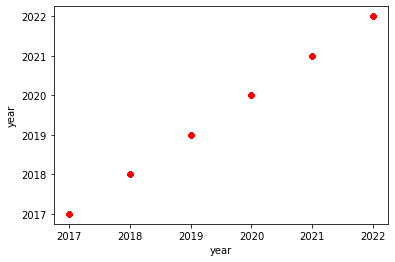

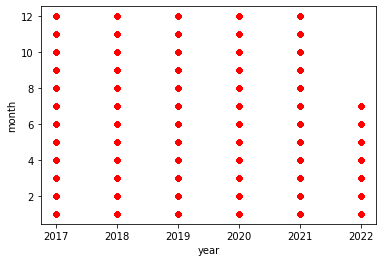

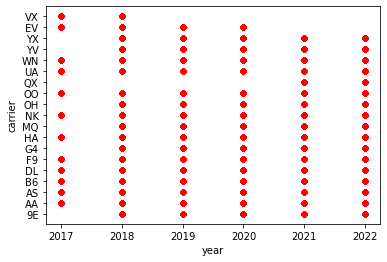

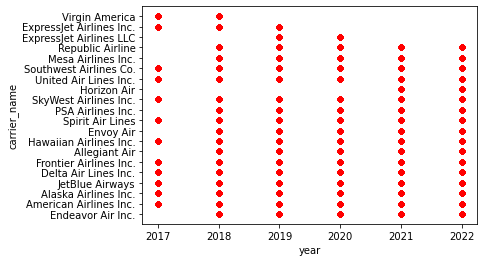

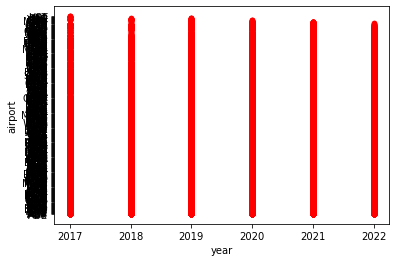

Error in callback <function flush_figures at 0x7f7999110b80> (for post_execute):


KeyboardInterrupt: 

In [12]:
# for column1 in df: 
#      for column2 in df: 
#             df.plot(kind='scatter', x=column1, y=column2, color='r')

In [13]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [14]:
df.dtypes

year                     int64
month                    int64
carrier                 object
carrier_name            object
airport                 object
airport_name            object
arr_flights            float64
arr_del15              float64
carrier_ct             float64
weather_ct             float64
nas_ct                 float64
security_ct            float64
late_aircraft_ct       float64
arr_cancelled          float64
arr_diverted           float64
arr_delay              float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
dtype: object

In [15]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')

/var/folders/9p/_jh1pnpx5xd6rbjhsjn79nc80000gn/T/ipykernel_10686/1305775564.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)
/var/folders/9p/_jh1pnpx5xd6rbjhsjn79nc80000gn/T/ipykernel_10686/1305775564.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)


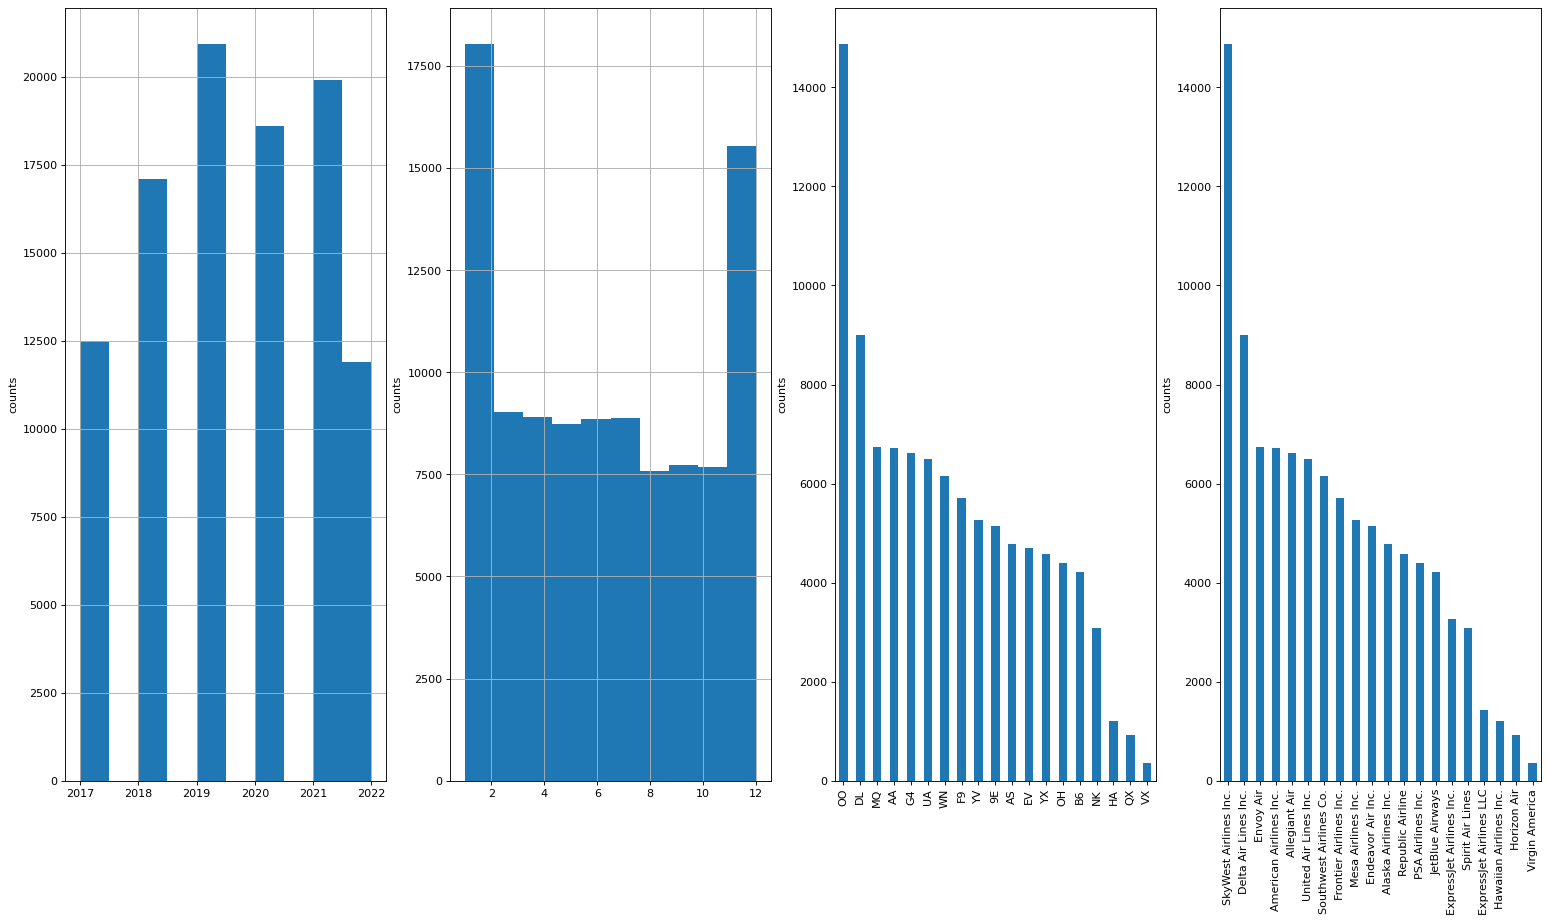

In [16]:
plotPerColumnDistribution(df, 10, 5)

In [17]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['arr_delay'].groupby(df['carrier']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
carrier,,,,
VX,0.0,59600.0,353.0,3879.657224
QX,0.0,41762.0,929.0,1237.678149
HA,0.0,32537.0,1202.0,1523.264559
NK,0.0,69102.0,3091.0,4131.395018
B6,0.0,160383.0,4218.0,6174.654576
OH,0.0,157438.0,4399.0,2550.615594
YX,0.0,89091.0,4583.0,3006.063714
EV,0.0,106924.0,4691.0,2418.601364
AS,0.0,83952.0,4782.0,1962.802802


In [18]:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['arr_delay'].groupby(df['airport']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
airport,,,,
FNL,0.0,0.0,1.0,0.000000
YNG,119.0,119.0,1.0,119.000000
IPT,212.0,941.0,3.0,631.333333
UST,17.0,1096.0,5.0,586.600000
ART,0.0,1377.0,6.0,725.333333
...,...,...,...,...
DTW,0.0,83386.0,889.0,8578.980877
MSY,0.0,29313.0,891.0,3069.169473
RDU,0.0,21340.0,906.0,3271.732892


In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["carrier"] = le.fit_transform(df[["carrier"]]);
df["carrier_name"] = le.fit_transform(df[["carrier_name"]]);
df["airport"] = le.fit_transform(df[["airport"]]);
df["airport_name"] = le.fit_transform(df[["airport_name"]]);



/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

In [20]:
from sklearn.preprocessing import MinMaxScaler
Y = df.iloc[:,-1]
# print(Y)
gh = df.drop(['late_aircraft_delay'], axis=1)

scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(
    gh, Y, test_size=.50, random_state=42)


X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [21]:
# X_train.shape
# X_train=X_train.to_numpy()
y_train=y_train.to_numpy()


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
Y = df.iloc[:,-1]
gh = df.drop(['late_aircraft_delay'], axis=1)

logModel = LogisticRegression(C=1, penalty='l1', solver='liblinear')
#LogisticRegression(C=1, penalty='l1', solver='liblinear')
a=logModel.fit(X_train,y_train)
# param_grid = [    
#     {'penalty' : ['l1','l2', 'elasticnet', 'none'],
#     'C' : np.logspace(-4, 4, 20),
#     'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
#     'max_iter' : [100, 1000, 2500, 5000]
#     }
# ]
# clf = GridSearchCV(logModel, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
# best_clf = clf.fit(X_train, y_train)

In [ ]:
lf = LogisticRegression()
best_clf=lf.fit(X_train,y_train)
y_pred=lf.predict(X_test)


In [34]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

In [26]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

array([[8.00000000e-01, 9.09090909e-02, 6.66666667e-01, ...,
        1.36219161e-03, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e-01, 9.09090909e-01, 9.44444444e-01, ...,
        0.00000000e+00, 1.90125364e-04, 0.00000000e+00],
       [8.00000000e-01, 7.27272727e-01, 2.22222222e-01, ...,
        3.64386257e-02, 1.14075218e-02, 0.00000000e+00],
       ...,
       [8.00000000e-01, 4.54545455e-01, 6.66666667e-01, ...,
        3.18979870e-02, 0.00000000e+00, 0.00000000e+00],
       [6.00000000e-01, 1.00000000e+00, 9.44444444e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.00000000e-01, 1.00000000e+00, 3.33333333e-01, ...,
        0.00000000e+00, 3.00635732e-03, 0.00000000e+00]])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()